In [ ]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [136]:
data = pd.read_csv("../data/state-daily-stats.csv", parse_dates=['date'])
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [137]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [138]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])
# daily_new_cases.set_index("date", inplace=True)

In [139]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

In [140]:
daily_new_cases.set_index("date", inplace=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

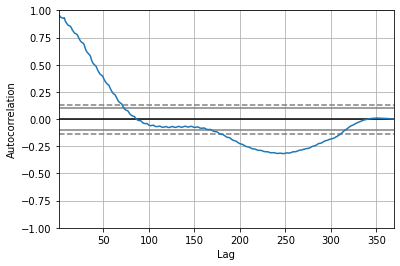

In [141]:
autocorrelation_plot(daily_new_cases)

In [142]:
log_daily_new_cases = pd.DataFrame(np.log(daily_new_cases.daily_new_cases))

<AxesSubplot:xlabel='date'>

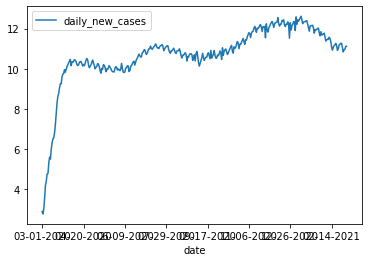

In [143]:
log_daily_new_cases.plot()

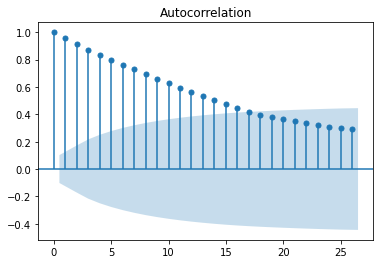

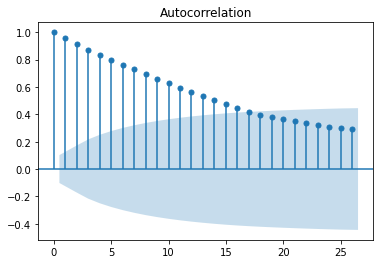

In [144]:
plot_acf(log_daily_new_cases)

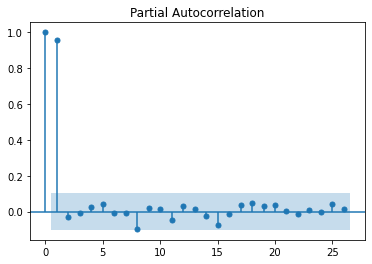

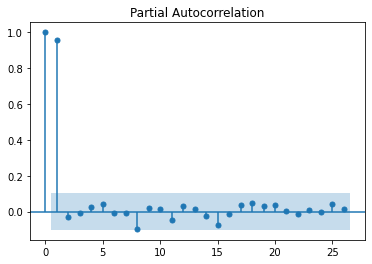

In [145]:
plot_pacf(log_daily_new_cases)

In [146]:
result = adfuller(log_daily_new_cases.daily_new_cases, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3196529392354193
p-value: 0.01402251976095639


In [172]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = ARIMA(log_daily_new_cases.daily_new_cases, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  368
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 123.091
Method:                       css-mle   S.D. of innovations              0.173
Date:                Fri, 05 Mar 2021   AIC                           -236.182
Time:                        18:51:26   BIC                           -216.641
Sample:                    03-02-2020   HQIC                          -228.418
                         - 03-04-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0688      0.077      0.894      0.371      -0.082       0.220
ar.L1.D.daily_new_cases     0.9927      0.008    117.427      0.000       0.976       1.009


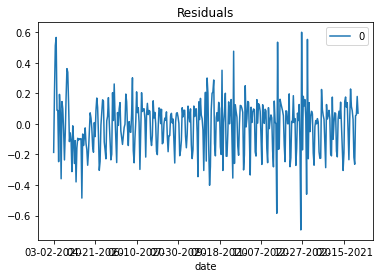

In [173]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()

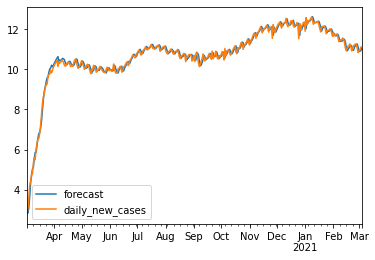

In [174]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [175]:
model_1_pred = model_fit.predict(dt.datetime(2021, 3, 5)) 

In [176]:
model_1_pred

2021-03-05   -0.020879
Freq: D, dtype: float64

In [177]:
x = np.expm1(model_1_pred[0])

In [178]:
np.expm1(x)

-0.0204502559843123

In [179]:
pd.DataFrame(model_1_pred)

,0
2021-03-05,-0.020879


In [180]:
model_1_pred[0]

-0.02087870899661534

In [27]:
training = log_daily_new_cases[:330]
testing = log_daily_new_cases[330:]

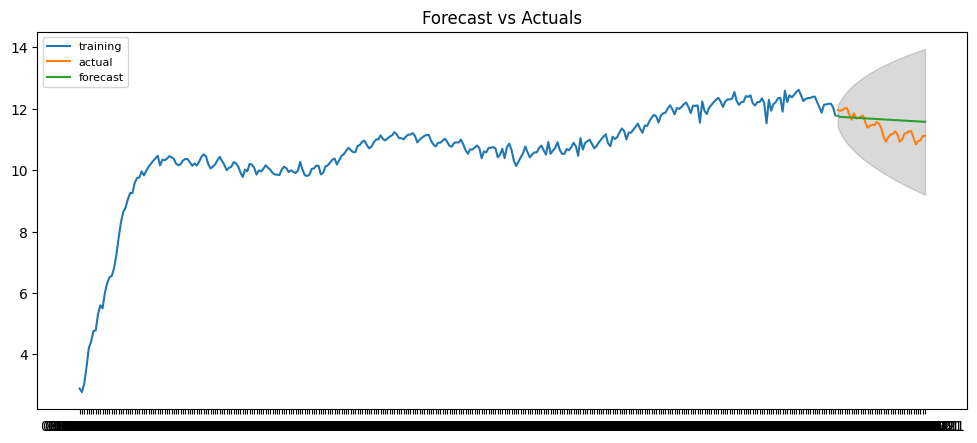

In [181]:
model = ARIMA(training, order=(1, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(39, alpha=0.05)  

# Forecast
# fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(testing, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### fitted.summary()

In [182]:
import pmdarima as pm

In [185]:
amodel = pm.auto_arima(log_daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(amodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-188.338, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2806.222, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2309.648, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-185.903, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-189.611, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1870.728, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-184.338, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-188.534, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1497.175, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-185.761, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-189.195, Time=0.36 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 2.339 seconds
                               SARIMAX Results                                
Dep. Variable:

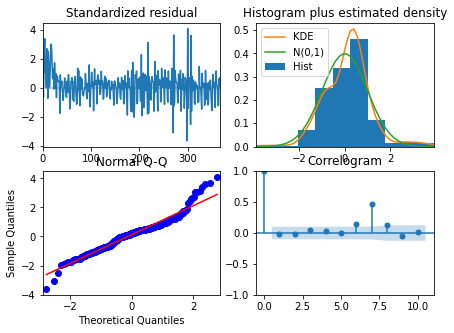

In [186]:
amodel.plot_diagnostics(figsize=(7,5))
plt.show()

<AxesSubplot:>

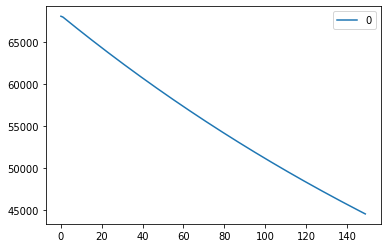

In [190]:
n_periods = 150
predictions = amodel.predict(n_periods=n_periods)
pd.DataFrame(np.expm1(predictions)).plot()

In [191]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(log_daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=-326.777, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=539.473, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-249.826, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=209.718, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=565.029, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=-245.369, Time=0.28 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=-327.700, Time=1.13 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=-301.333, Time=0.93 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=-328.408, Time=2.07 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=-326.931, Time=1.64 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=110.495, Time=0.86 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(2,0,1)(1,1,2)[7] intercept   : AIC=-322.243, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  369
Model:             SARIMAX(1, 0, 3)x(1, 1, [1, 2], 7)   Log Likelihood                 182.263
Date:                                Fri, 05 Mar 2021   AIC                           -348.527
Time:                                        18:55:43   BIC                           -317.394
Sample:                                             0   HQIC                          -336.150
                                                - 369                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.001   1221.322      0.000       0.998       1.001
ma.L1         -0.3574      0.029    -12.280      0.000      -0.414      -0.300
ma.L2          0.1268      0.058      2.194      0.028       0.014       0.240
ma.L3          0.1451      0.057      2.561      0.010       0.034       0.256
ar.S.L7        0.6300      0.187      3.375      0.001       0.264       0.996
ma.S.L7       -1.2720      0.200     -6.370      0.000      -1.663      -0.881
ma.S.L14       0.3220      0.163      1.977      0.048       0.003       0.641
sigma2         0.0208      0.001     25.983      0.000       0.019       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               765.09
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.07
Prob(H) (two-sided):                  0.52   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
n_periods = 30
predictions_seasonal = smodel.predict(n_periods=n_periods)

<AxesSubplot:>

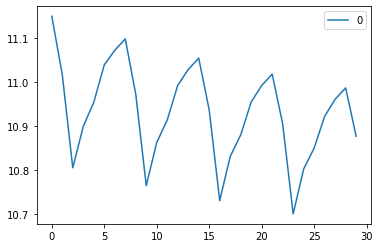

In [77]:
pd.DataFrame(predictions_seasonal).plot()

In [105]:
# predictions_df = pd.DataFrame(predictions_seasonal)

predictions_list = []

for x in predictions_seasonal:
    prediction = np.expm1(x)
    predictions_list.append(round(prediction))

# pd.DataFrame(np.expm1(predictions_seasonal))

predicted_dates = []

date = dt.date.today() - dt.timedelta(days=1)

for x in predictions_seasonal:
    date += dt.timedelta(days=1)
    predicted_dates.append(date)

In [130]:
predictions_df = pd.DataFrame({"future_date":predicted_dates, "predicted_daily_new_cases":predictions_list})
predictions_df.set_index("future_date", inplace=True)

<AxesSubplot:xlabel='future_date'>

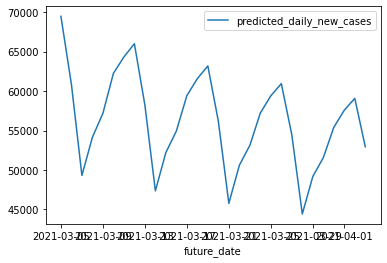

In [131]:
predictions_df.plot()

In [133]:
predictions_df.to_csv("../data/daily_new_cases_predicitions.csv")

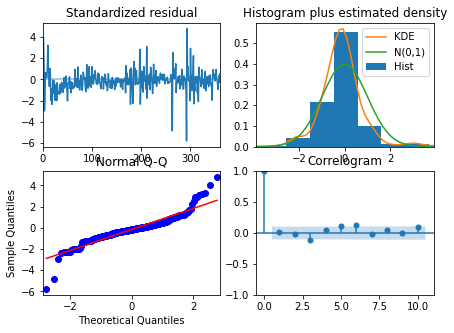

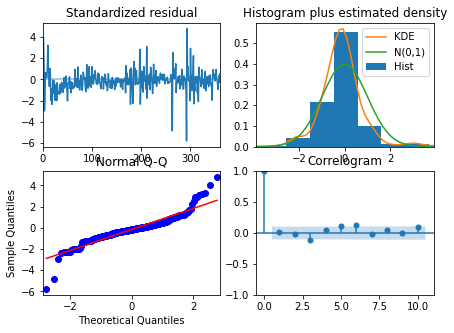

In [134]:
smodel.plot_diagnostics(figsize=(7,5))